In [52]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,confusion_matrix,roc_curve
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


In [94]:
banned = pd.read_csv('data/ban_df.csv', converters={'comments': eval})
subs = pd.read_csv('data/df_watchexchange.csv', converters={'comments': eval})
banned['is_scammer'] = True
subs['is_scammer'] = False

df = pd.concat([banned,subs], ignore_index=True)
df['comments_new'] = df['comments'].map(lambda x: " ".join(x))

In [97]:
#baseline vectorizer parameters

vec = TfidfVectorizer(
    stop_words='english',
    min_df=3,  # min count for relevant vocabulary
    max_features=5000,  # maximum number of features
    strip_accents='unicode',  # replace all accented unicode char 
    # by their corresponding  ASCII char
    analyzer='word',  # features made of words
    token_pattern=r'[a-zA-Z]{4,}',  # tokenize only words of 3+ chars
     ngram_range=(1, 1),  # features made of a single tokens
    use_idf=True,  # enable inverse-document-frequency reweighting
    smooth_idf=True,  # prevents zero division for unseen words
    sublinear_tf=False)

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
X = df['comments_new']
y = df['is_scammer']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [98]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(vec, MultinomialNB())
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents='unicode',
                                 sublinear_tf=False,
                                 token_pattern='[a-zA-Z]{4,}', tokenizer=None,
                                 use_idf=True, vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [99]:
y_pred = model.predict_proba(X_test)[:, 1]

In [100]:
roc_auc_score(y_test,y_pred)
#baseline score

0.9523957470312069

In [50]:
threshold = .17
predicted = y_pred >= threshold
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)

accuracy: 0.883419689119171
precision: 0.7021276595744681
recall: 0.9705882352941176


Text(89.18, 0.5, 'predicted label')

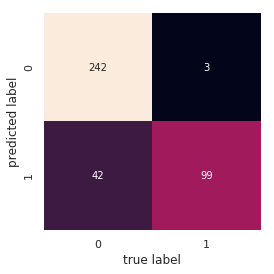

In [93]:
mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [67]:
roc_y_test = y_test.map(int)

In [68]:
fpr, tpr, thresholds = roc_curve(roc_y_test, y_pred, pos_label=1)

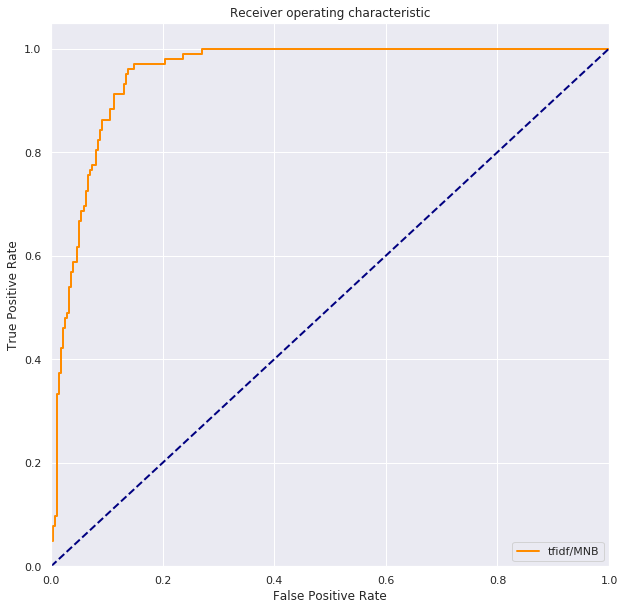

In [78]:
fig,ax = plt.subplots(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='tfidf/MNB')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()